In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import keras
import tensorflow as tf

# Metrics / utils
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import TensorBoard

# Keras model/layers
from keras.models import Model, Sequential
from keras.layers import (
    Input, Dense, LSTM,
    Conv1D, Dropout, Add, Activation,
    LayerNormalization, GlobalAveragePooling1D
)

from PIL import Image, ImageDraw, ImageFont


In [2]:
mp_hol = mp.solutions.holistic
mp_draw = mp.solutions.drawing_utils

In [3]:
def mp_detect(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    result = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, result

In [4]:
def draw_lm(image, results):
    mp_draw.draw_landmarks(image, results.left_hand_landmarks, mp_hol.HAND_CONNECTIONS)
    mp_draw.draw_landmarks(image, results.right_hand_landmarks, mp_hol.HAND_CONNECTIONS)

In [5]:
def draw_styled_lm(image, results): 
    mp_draw.draw_landmarks(image, results.left_hand_landmarks, mp_hol.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )   
    mp_draw.draw_landmarks(image, results.right_hand_landmarks, mp_hol.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(155,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(155,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
def ext_keypoints(results1):
    lh = np.array([[res.x, res.y, res.z] for res in results1.left_hand_landmarks.landmark]).flatten() if results1.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results1.right_hand_landmarks.landmark]).flatten() if results1.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [ ]:
cap = cv2.VideoCapture(0)
with mp_hol.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        image, results1 = mp_detect(frame, holistic)
        print(results1)

        draw_styled_lm(image, results1)

        cv2.imshow('QazSign', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [24]:
DATA_PATH = os.path.join('Data_1') 

actions = np.array(['сәлеметсіз бе', 'сау болыңыз','аты','тегі','әкесінің аты','бір','мектеп'])

no_seq = 60

seq_length = 30

start_folder = 1

In [25]:
for action in actions: 
    for sequence in range(1,no_seq+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [18]:
cap = cv2.VideoCapture(0)

with mp_hol.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    

    for action in actions:

        for sequence in range(start_folder, no_seq+start_folder):

            for frame_num in range(seq_length):

                ret, frame = cap.read()

                image, results1 = mp_detect(frame, holistic)

                draw_styled_lm(image, results1)

                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('QazSign', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('QazSign', image)
                
                keypoints = ext_keypoints(results1)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [26]:
label_map = {label:num for num, label in enumerate(actions)}

In [27]:
sequences, labels = [], []
for action in actions:
    for sequence in range(1, no_seq):
        window = []
        for frame_num in range(seq_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [28]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, stratify=y)

In [30]:
np.array(sequences).shape

(413, 30, 126)

In [31]:
log_dir1 = os.path.join('Logs1')
tb_callback = TensorBoard(log_dir=log_dir1)

In [32]:
# TCN (Temporal Convolutional Network) model for real-time gesture recognition
# - causal Conv1D ensures no "future" leakage (online-friendly)
# - dilated convolutions expand receptive field efficiently
# - residual blocks stabilize training

def tcn_residual_block(x, filters=128, kernel_size=3, dilation_rate=1, dropout=0.15):
    shortcut = x

    x = Conv1D(filters, kernel_size, padding="causal", dilation_rate=dilation_rate)(x)
    x = LayerNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout)(x)

    x = Conv1D(filters, kernel_size, padding="causal", dilation_rate=dilation_rate)(x)
    x = LayerNormalization()(x)

    # Match channels if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding="same")(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

inputs = Input(shape=(30, 126), name="keypoints_30x126")

# Stem (light projection)
x = Conv1D(128, kernel_size=1, padding="same")(inputs)
x = LayerNormalization()(x)
x = Activation("relu")(x)

# Dilations -> receptive field grows quickly
for d in [1, 2, 4, 8]:
    x = tcn_residual_block(x, filters=128, kernel_size=3, dilation_rate=d, dropout=0.15)

# For isolated-gesture classification: pool over time
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)

outputs = Dense(actions.shape[0], activation="softmax", name="gesture_softmax")(x)

model = Model(inputs=inputs, outputs=outputs, name="TCN_GestureClassifier")
model.summary()


Model: "TCN_GestureClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keypoints_30x126 (InputLayer) │ (None, 30, 126)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_9 (Conv1D)             │ (None, 30, 128)           │          16,256 │ keypoints_30x126[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_9         │ (None, 30, 128)           │             256 │ conv1d_9[0][0]             │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_9 (Activation)     │ (None, 30, 128)           │               0 │ layer_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_10 (Conv1D)            │ (None, 30, 128)           │          49,280 │ activation_9[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_10        │ (None, 30, 128)           │             256 │ conv1d_10[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_10 (Activation)    │ (None, 30, 128)           │               0 │ layer_normalization_10[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 30, 128)           │               0 │ activation_10[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_11 (Conv1D)            │ (None, 30, 128)           │          49,280 │ dropout_5[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_11        │ (None, 30, 128)           │             256 │ conv1d_11[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_4 (Add)                   │ (None, 30, 128)           │               0 │ layer_normalization_11[0]… │
│                               │                           │                 │ activation_9[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_11 (Activation)    │ (None, 30, 128)           │               0 │ add_4[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_12 (Conv1D)            │ (None, 30, 128)           │          49,280 │ activation_11[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_12        │ (None, 30, 128)           │             256 │ conv1d_12[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_12 (Activation)    │ (None, 30, 128)           │               

 Total params: 423,367 (1.62 MB)

 Trainable params: 423,367 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [17]:
model.fit(X_train, y_train,epochs=100, callbacks=[tb_callback])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - categorical_accuracy: 0.2095 - loss: 1.9140
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.4020 - loss: 1.4621
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.5322 - loss: 1.2075
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.6273 - loss: 0.9487
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.6931 - loss: 0.7471
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.7348 - loss: 0.6691
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.8356 - loss: 0.4280
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.9207 - loss: 0.2480
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.9240 - loss: 0.1989
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.9796 - loss: 0.0814
Epoch 11/100
11/11 

In [36]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


In [37]:
y_hat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [38]:
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(y_hat, axis=1).tolist()

In [39]:
accuracy_score(y_true, y_hat)

1.0

In [40]:
model.save('action_150220266.h5')

In [23]:
# (Optional) delete model to free memory
del model

In [28]:
# Reload model weights (architecture must be re-created in the current session)
# If you've restarted the kernel, run the model-definition cell again first.
model.load_weights('action_15022026.h5')

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - categorical_accuracy: 0.1719 - loss: 2.2353 - val_categorical_accuracy: 0.5238 - val_loss: 1.5142
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.3907 - loss: 1.6215 - val_categorical_accuracy: 0.5714 - val_loss: 0.9795
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.5527 - loss: 1.0866 - val_categorical_accuracy: 0.8095 - val_loss: 0.7203
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.6614 - loss: 0.8659 - val_categorical_accuracy: 0.7619 - val_loss: 0.6037
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.7286 - loss: 0.6581 - val_categorical_accuracy: 0.9524 - val_loss: 0.3343
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.8269 - loss: 0.5089 - val_categorical_accuracy: 0.8571 - val_loss: 0.3424
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.8230 - lo

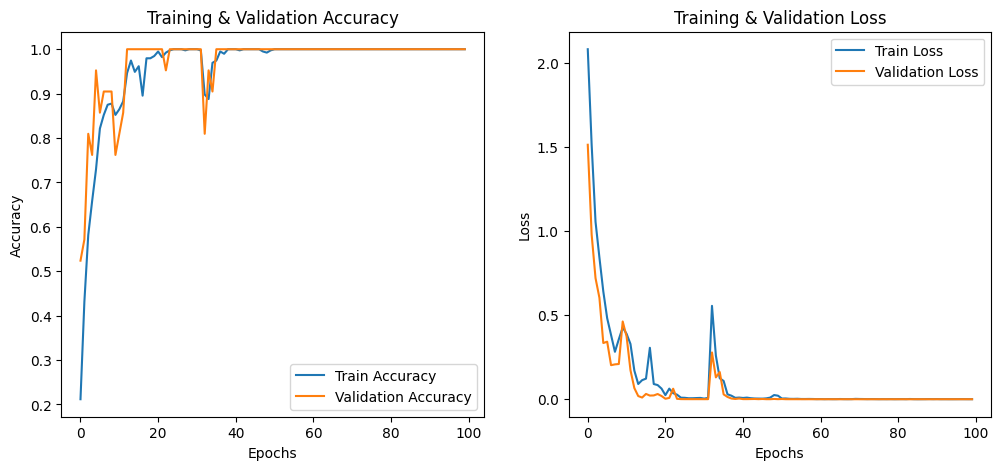

In [34]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[tb_callback])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

In [42]:
p = r"C:\Users\turat\Desktop\Программы(Портфолио)\Infomatrix\2026\code\Logss0\train"
print("exists:", os.path.exists(p))
print("isdir :", os.path.isdir(p))
print("isfile:", os.path.isfile(p))


exists: True
isdir : True
isfile: False


In [34]:
import os
import shutil
from tensorflow.keras.callbacks import TensorBoard

log_dir = r"C:\Users\turat\Desktop\Программы(Портфолио)\Infomatrix\2026\code\Logss0\train"

# 1) Если log_dir существует как файл — удалить
if os.path.exists(log_dir) and not os.path.isdir(log_dir):
    os.remove(log_dir)

# 2) Если корневая "Logss0" существует как файл — удалить (частая причина)
root_dir = os.path.dirname(os.path.dirname(log_dir))  # ...\Logss0
if os.path.exists(root_dir) and not os.path.isdir(root_dir):
    os.remove(root_dir)

# 3) Создать директории
os.makedirs(log_dir, exist_ok=True)

# 4) TensorBoard callback
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
print("TensorBoard logs dir:", log_dir)

TensorBoard logs dir: C:\Users\turat\Desktop\Программы(Портфолио)\Infomatrix\2026\code\Logss0\train


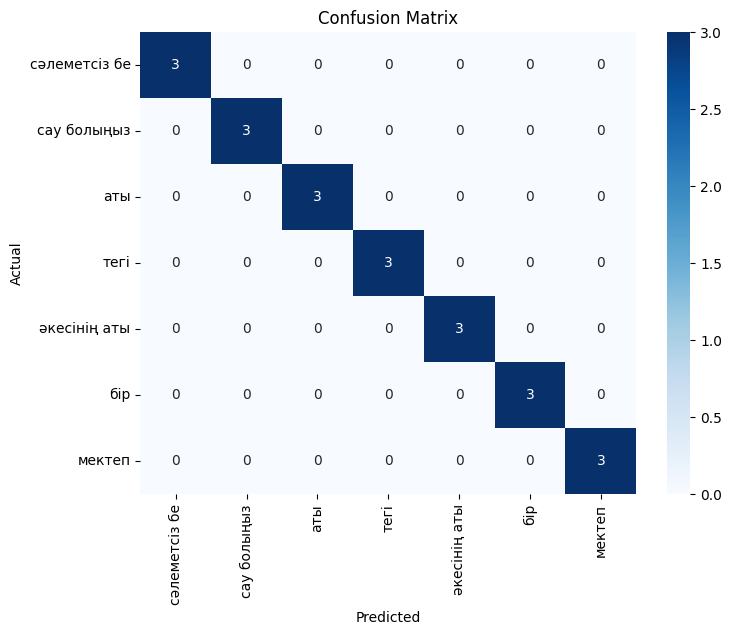

In [41]:
import seaborn as sns
cm = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
def draw_text(image, text, position=(20, 40), font_path="arial.ttf", font_size=32, color=(0, 255, 0)):
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    draw.text(position, text, font=font, fill=color)

    return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

In [ ]:
def predict_gesture(model, sequence):
    sequence = np.expand_dims(sequence, axis=0) 
    prediction = model.predict(sequence)
    return np.argmax(prediction), np.max(prediction)  


cap = cv2.VideoCapture(0)

sequence = []  
threshold = 0.8  

with mp_hol.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image, result = mp_detect(frame, holistic)
        draw_styled_lm(image, result)
    
        keypoints = ext_keypoints(result)
        sequence.append(keypoints)
        sequence = sequence[-30:]  

        if len(sequence) == 30:
            action_class, confidence = predict_gesture(model, np.array(sequence))

            if confidence > threshold:
                text = f"{actions[action_class]} ({confidence:.2f})"
                image = draw_text(image, text)

            cv2.imshow('QazSign', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

C:\QazSign\python\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━